In [1]:
from subpred.protein_go_datasets import get_transmembrane_transporter_dataset, get_stats

## Full dataset

In [2]:
dataset_athaliana = get_transmembrane_transporter_dataset(  # athaliana
    organism_ids=[3702],
    swissprot_only=False,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=False,
    max_sequence_evidence_code=2,
    remove_proteins_without_gene_names=False,
)
get_stats(*dataset_athaliana)

cd-hit: clustered 1773 sequences into 646 clusters at threshold 50
cd-hit: clustered 1773 sequences into 923 clusters at threshold 70
cd-hit: clustered 1773 sequences into 1203 clusters at threshold 90
cd-hit: clustered 1773 sequences into 1554 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence   protein_existence_evidence clustering                   
False              False         computational protein_level              100                      3   
                                                                          None                     3   
                                               transcript_level           50                       3   
                                                                          70                       4   
                                                                          90                       7   
                                                                          100                     37   
                                                                          None                    49   
                   True          computational protein_level              50                      87   
                                                                          70                     114   
                                                                          90                     153   
                                                                          100                    329   
                                                                          None                   433   
                                               transcript_level           50                       7   
                                                                          70                      13   
                                                                          90                      19   
                                                                          100                     84   
                                                                          None                   164   
                                 experiment    protein_level              50                      25   
                                                                          70                      33   
                                                                          90                      38   
                                                                          100                     41   
                                                                          None                    42   
                                               transcript_level           50                       3   
                                                                          70                       5   
                                                                          90                       5   
                                                                          100                      6   
                                                                          None                     6   
True               True          computational protein_level              50                     206   
                                                                          70                     287   
                                                                          90                     370   
                                                                          100                    408   
                                                                          None                   418   
                                               transcript_level           50                     208   
                                                                          70                     338   
                                                                          90                     462   
                                                                          100                    492   
                                                                          None                   504   
                              

## Filtered Subset

In [3]:
dataset_athaliana = get_transmembrane_transporter_dataset(  # athaliana
    organism_ids=[3702],
    swissprot_only=True,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=True,
    max_sequence_evidence_code=1,
    remove_proteins_without_gene_names=True,
)
get_stats(*dataset_athaliana)

cd-hit: clustered 420 sequences into 276 clusters at threshold 50
cd-hit: clustered 420 sequences into 344 clusters at threshold 70
cd-hit: clustered 420 sequences into 403 clusters at threshold 90
cd-hit: clustered 420 sequences into 419 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering                   
True               True          experiment  protein_level              50                     276   
                                                                        70                     344   
                                                                        90                     403   
                                                                        100                    419   
                                                                        None                   420   

                                                                                    n_terms  
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering           
True               True          experiment  protein_level              50              264  
                                                                        70              281  
                                                                        90              288  
                                                                        100             288  
                                                                        None            288

## Sugar/Amino subset

In [4]:
def get_classification_subset(dataset_full, go_terms:list):
    df_sequences, df_uniprot_goa = dataset_full[0].copy(), dataset_full[1].copy()
    df_uniprot_goa = (
        df_uniprot_goa[
            df_uniprot_goa.go_term_ancestor.isin(
                go_terms
            )
        ][["Uniprot", "go_term_ancestor"]]
        .drop_duplicates()
        .reset_index(drop=True)
    ).set_index("Uniprot")
    # Transporters that are annotated with both terms (might happen for other datasets)
    assert not df_uniprot_goa.index.duplicated().any()
    df_sequences = df_sequences[
        df_sequences.index.isin(df_uniprot_goa.index)
    ]
    return df_sequences, df_uniprot_goa    

In [5]:
dataset_athaliana = get_classification_subset(dataset_full=dataset_athaliana, go_terms=[
                "sugar transmembrane transporter activity",
                "amino acid transmembrane transporter activity",
            ])

print("before clustering:")
dataset_athaliana[1].go_term_ancestor.value_counts()

before clustering:


go_term_ancestor
amino acid transmembrane transporter activity    33
sugar transmembrane transporter activity         32
Name: count, dtype: int64

Clustering at 70%

In [6]:
from subpred.cdhit import cd_hit
def cluster_sequences(dataset_full, identity_threshold:int):
    df_sequences, df_uniprot_goa = dataset_full[0].copy(), dataset_full[1].copy()
    cluster_representatives = set(
        cd_hit(df_sequences.sequence, identity_threshold=identity_threshold)
    )
    df_sequences = df_sequences[
        df_sequences.index.isin(cluster_representatives)
    ]
    df_uniprot_goa = df_uniprot_goa[
        df_uniprot_goa.index.isin(cluster_representatives)
    ]
    return df_sequences, df_uniprot_goa

In [7]:
dataset_athaliana = cluster_sequences(dataset_full=dataset_athaliana, identity_threshold=70)
dataset_athaliana[1].go_term_ancestor.value_counts()

cd-hit: clustered 65 sequences into 54 clusters at threshold 70


go_term_ancestor
sugar transmembrane transporter activity         28
amino acid transmembrane transporter activity    26
Name: count, dtype: int64

## Feature generation

In [8]:
from subpred.features import calculate_features
from subpred.pssm import calculate_pssm_feature
from subpred.compositions import calculate_comp, ALPHABET_3DI, AMINO_ACIDS
from subpred.structural_sequences import get_3Di_sequences
from subpred.embeddings import get_nlp_features
import pandas as pd
import numpy as np


def get_features(dataset_full:tuple):
    # Can take a long time if cache is empty
    df_sequences, df_uniprot_goa = dataset_full[0].copy(), dataset_full[1].copy()
    series_sequences = df_sequences.sequence
    series_accessions = df_sequences.index

    # 3Di sequences
    sequences_3Di = get_3Di_sequences(series_accessions)
    # Are there as many 3Di sequences as AA sequences? TODO If yes, maybe take intersection
    assert len(sequences_3Di) == len(series_sequences)

    # original sequences features
    df_aac = calculate_comp(series_sequences, k=1, alphabet=AMINO_ACIDS)
    df_paac = calculate_comp(series_sequences, k=2, alphabet=AMINO_ACIDS)
    df_kmer3 = calculate_comp(series_sequences, k=3, alphabet=AMINO_ACIDS)

    pssm_folder = "../data/datasets/pssm/"
    blastdb_folder = "../data/datasets/blastdb/"
    verbosity_pssm = 1  # only print if no pssm found
    df_pssm_50_1 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref50_1it",
        blast_db=blastdb_folder + "uniref50/uniref50.fasta",
        iterations=1,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_50_1",
    )
    df_pssm_50_3 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref50_3it",
        blast_db=blastdb_folder + "uniref50/uniref50.fasta",
        iterations=3,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_50_3",
    )
    df_pssm_90_1 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref90_3it",
        blast_db=blastdb_folder + "uniref90/uniref90.fasta",
        iterations=1,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_90_1",
    )
    df_pssm_90_3 = calculate_pssm_feature(
        series_sequences,
        tmp_folder=pssm_folder + "pssm_uniref90_3it",
        blast_db=blastdb_folder + "uniref90/uniref90.fasta",
        iterations=3,
        psiblast_threads=-1,
        verbosity=verbosity_pssm,
        feature_name="PSSM_90_3",
    )
    df_pssm_meta = pd.concat(
        [df_pssm_50_1, df_pssm_50_3, df_pssm_90_1, df_pssm_90_3], axis=1
    )
    df_meta = calculate_features(series_sequences=series_sequences, standardize_samples=False)
    df_meta_std = calculate_features(series_sequences=series_sequences, standardize_samples=True)

    df_3Di_AAC = calculate_comp(sequences=sequences_3Di, k=1, alphabet=ALPHABET_3DI)
    df_3Di_PAAC = calculate_comp(sequences=sequences_3Di, k=2, alphabet=ALPHABET_3DI)
    df_3Di_KMER3 = calculate_comp(sequences=sequences_3Di, k=3, alphabet=ALPHABET_3DI)

    # AA Embeddings
    df_embeddings_prott5_AA = get_nlp_features(
        sequences=series_sequences,
        model="protT5",
        sequence_type="AA",
        half_precision=True,
    )
    df_embeddings_prostt5_AA = get_nlp_features(
        sequences=series_sequences,
        model="prostT5",
        sequence_type="AA",
        half_precision=True,
    )
    # 3Di Embeddings
    df_embeddings_prott5_3Di = get_nlp_features(
        sequences=sequences_3Di,
        model="prostT5",
        sequence_type="3Di",
        half_precision=True,
    )

    np.random.seed(0)
    df_dummy_feature = pd.DataFrame(
        np.random.rand(len(series_accessions), 1024),
        index=series_accessions,
        columns=[f"dummy{i}" for i in range(1024)],
    )

    features_list = [
        ("AAC", df_aac.loc[series_accessions]),
        ("PAAC", df_paac.loc[series_accessions]),
        ("AA_KMER3", df_kmer3.loc[series_accessions]),
        ("PSSM_50_1", df_pssm_50_1.loc[series_accessions]),
        ("PSSM_50_3", df_pssm_50_3.loc[series_accessions]),
        ("PSSM_90_1", df_pssm_90_1.loc[series_accessions]),
        ("PSSM_90_3", df_pssm_90_3.loc[series_accessions]),
        ("PSSM_META", df_pssm_meta.loc[series_accessions]),
        ("META",df_meta),
        ("META_STD",df_meta_std),
        ("3Di_COMP", df_3Di_AAC.loc[series_accessions]),
        ("3Di_KMER2", df_3Di_PAAC.loc[series_accessions]),
        ("3Di_KMER3", df_3Di_KMER3.loc[series_accessions]),
        ("PROTT5_AA", df_embeddings_prott5_AA.loc[series_accessions]),
        ("PROSTT5_AA", df_embeddings_prostt5_AA.loc[series_accessions]),
        ("PROSTT5_3DI", df_embeddings_prott5_3Di.loc[series_accessions]),
        ("DUMMY", df_dummy_feature.loc[series_accessions]),
    ]
    series_labels = (
        df_uniprot_goa.loc[series_accessions]
        .go_term_ancestor
    )
    return features_list, series_labels

2025-05-24 01:37:47.127666: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 01:37:47.135190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748043467.141116    7615 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748043467.143053    7615 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-24 01:37:47.150370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [9]:
features_list, series_labels = get_features(dataset_full=dataset_athaliana)

For each Feature: Outlier detection, numpy conversion 

In [10]:
from sklearn.preprocessing import LabelEncoder


def get_ml_dataset(df_features:pd.DataFrame, series_labels:pd.Series):
    assert not series_labels.index.duplicated().any()
    assert (df_features.index == series_labels.index).all()

    sample_names = df_features.index.to_numpy()
    feature_names = df_features.columns.to_numpy()

    label_encoder = LabelEncoder()

    X = df_features.loc[sample_names].to_numpy()
    y_str = series_labels.loc[sample_names].to_numpy().ravel()
    y = label_encoder.fit_transform(y_str)

    return X, y, sample_names, feature_names

In [11]:
ml_datasets = [(feature_name, *get_ml_dataset(df_features=df_features, series_labels=series_labels)) for feature_name, df_features in features_list]
ml_datasets

[('AAC',
  array([[0.06639004, 0.00414938, 0.02074689, ..., 0.10373444, 0.01659751,
          0.05394191],
         [0.07708333, 0.02083333, 0.03333333, ..., 0.11666667, 0.02291667,
          0.0375    ],
         [0.07287449, 0.0242915 , 0.02834008, ..., 0.08502024, 0.00809717,
          0.03238866],
         ...,
         [0.05818182, 0.01818182, 0.03818182, ..., 0.07454545, 0.01090909,
          0.04909091],
         [0.08243728, 0.01075269, 0.02867384, ..., 0.07526882, 0.0125448 ,
          0.03405018],
         [0.0867052 , 0.01541426, 0.00770713, ..., 0.06358382, 0.0327553 ,
          0.03468208]], shape=(54, 20)),
  array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
         1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0,
         0, 0, 0, 1, 0, 1, 0, 0, 1, 0]),
  array(['Q84WN3', 'Q8GUM3', 'Q8L9J7', 'Q8VZ80', 'Q9FMF7', 'Q9SMM5',
         'Q94KE0', 'Q9C8E7', 'Q9FG00', 'Q9FKS8', 'Q9FY94', 'O81845',
         'Q8GX78', 'Q8LFH5', 'Q9CA93', 'Q9

In [17]:
# saving as pickle, to load in different notebook and try to solve conflicts
import pickle
with open("../data/tmp/ml_data_at_sugaramino.pickle", 'wb') as handle:
    pickle.dump(ml_datasets, handle)

# with open("../data/tmp/ml_data_at_sugaramino.pickle", "rb") as handle:
#     ml_datasets_from_pickle = pickle.load(handle)

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest

def find_outliers(X:np.array):
    outlier_detector = make_pipeline(
        StandardScaler(),
        PCA(n_components=0.95),
        IsolationForest(contamination="auto", random_state=0),
    )
    outliers = outlier_detector.fit_predict(X)  # -1 for outliers, 1 for inliers
    is_outlier = outliers == -1
    print(is_outlier.sum(), "outliers found")
    return is_outlier

    # remove_outliers = False
    # if remove_outliers:
    #     X = X[outliers != -1]
    #     y = y[outliers != -1]

outliers = np.array([find_outliers(X) for feature_name, X, _, sample_names, _ in ml_datasets])

df_outliers = pd.Series(index=ml_datasets[0][3], data=outliers.sum(axis=0)).sort_values(
    ascending=False
).to_frame(name="outlier_count").join(dataset_athaliana[0].protein_names).join(dataset_athaliana[1])

df_outliers = df_outliers[df_outliers.outlier_count >= len(ml_datasets)*0.8]
# potential outliers to manually check TODO useful?
df_outliers

7 outliers found
0 outliers found
0 outliers found
8 outliers found
7 outliers found
11 outliers found
11 outliers found
5 outliers found
5 outliers found
1 outliers found
6 outliers found
1 outliers found
0 outliers found
10 outliers found
9 outliers found
6 outliers found
0 outliers found


,outlier_count,protein_names,go_term_ancestor


In [ ]:
import seaborn as sns

# sns.clustermap(X, row_colors=["yellow" if label == 1 else "blue" for label in y])

## Model evaluation SVM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    RepeatedStratifiedKFold,
    StratifiedKFold,
)
from sklearn.metrics import f1_score, balanced_accuracy_score
def nested_crossval(feature_name, X, y, sample_names, feature_names):
    print(f"=== {feature_name} ===")
    model = make_pipeline(VarianceThreshold(), StandardScaler(), SelectKBest(), SVC())

    max_features = min(len(feature_names), 200)

    param_grid = {
        "selectkbest__k": list(range(1, max_features, 1)),
        "svc__class_weight": ["balanced"],
        "svc__C":[0.1, 1, 10],
        "svc__gamma": ["scale"]
    }  
    # scale : 1 / (n_features * X.var()). 
    # larger variance and more features leads to a smoother decision boundary, 
    # where each sample has less influence

    gridsearch = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="balanced_accuracy",
        cv=StratifiedKFold(5),
        n_jobs=-1,
    )

    # Nested loop (sound results):
    gridsearch.n_jobs = 1
    nested_crossval_results = cross_val_score(
        gridsearch,
        X,
        y,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=0),
        scoring="balanced_accuracy",
        n_jobs=-1,
    )
    print(f"Nested crossvalidation: {nested_crossval_results.mean():.2f}+-{nested_crossval_results.std():.2f}")
    return nested_crossval_results


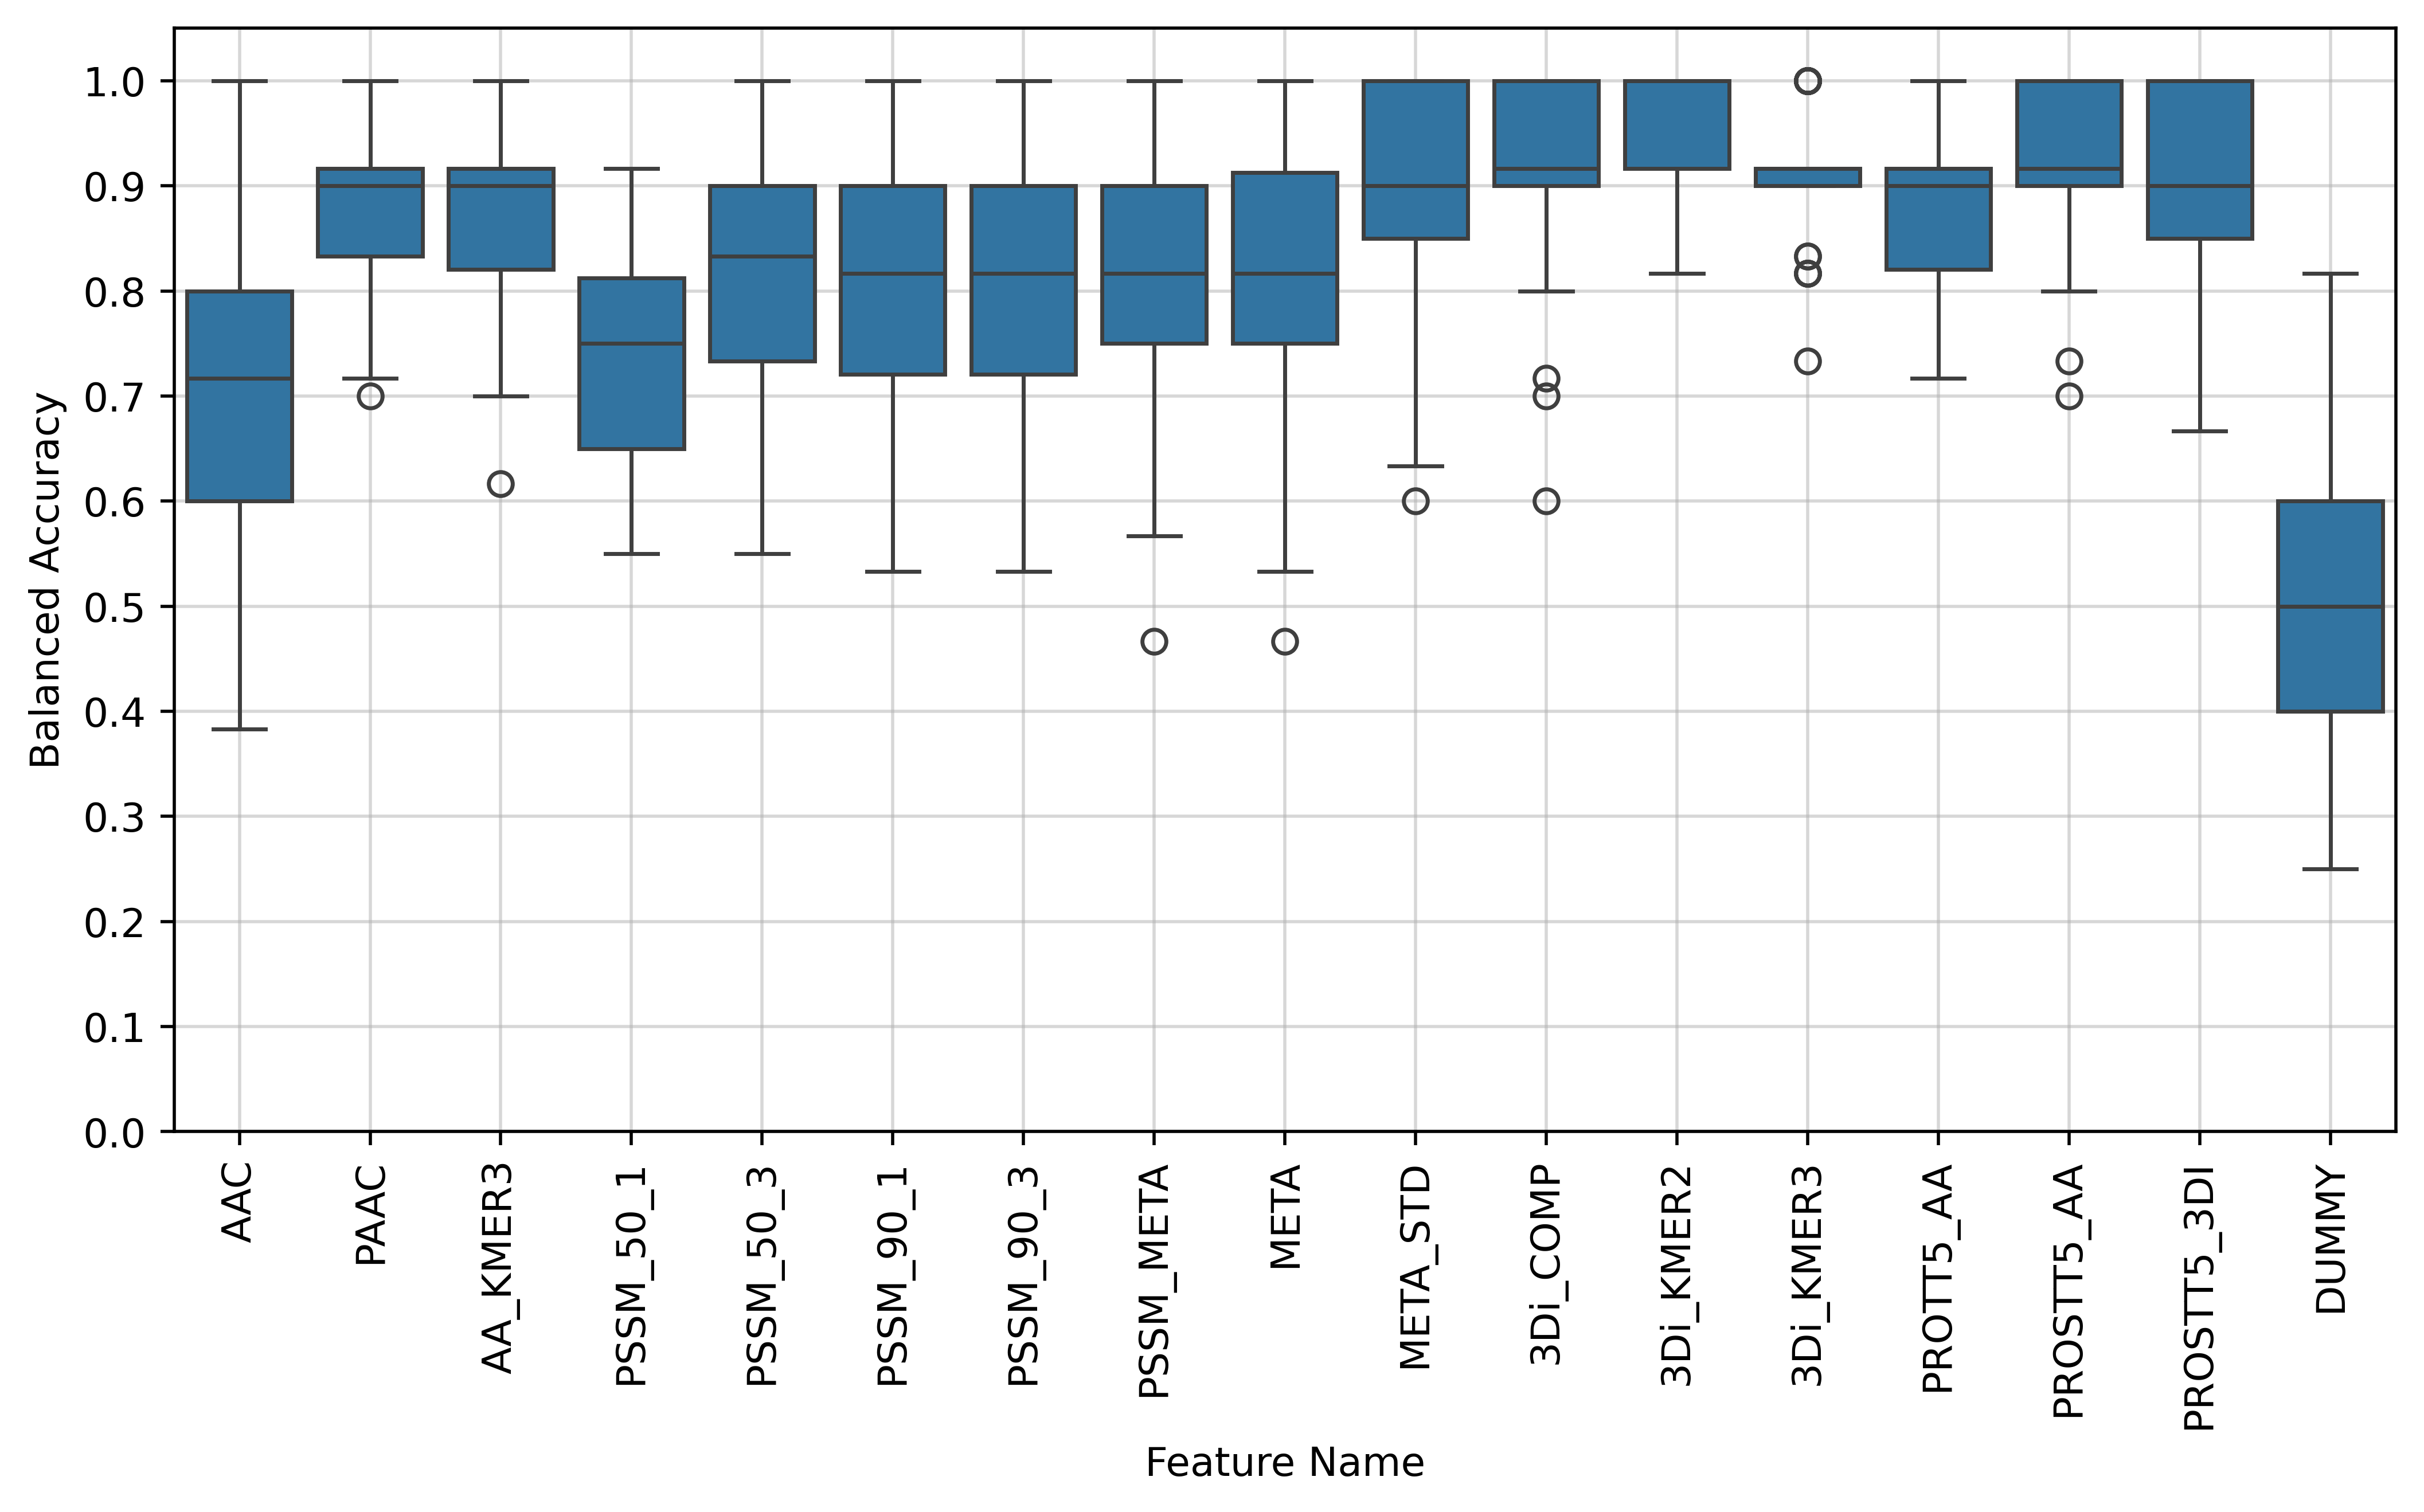

In [ ]:
from subpred.util import save_data, load_data
import matplotlib.pyplot as plt
import seaborn as sns

RESULTS_FOLDER="../data/results/"
TEST_NAME = "svc_athaliana_sugar_amino"
RECALCULATE = False # TODO

if RECALCULATE:
    # takes about 20 min
    results_rbf_svm = [
        (ml_dataset[0], nested_crossval(*ml_dataset)) for ml_dataset in ml_datasets
    ]

    results_long = list()
    for feature_name, test_results in results_rbf_svm:
        for test_result in test_results:
            results_long.append((feature_name, test_result))

    df_results_long = pd.DataFrame.from_records(
        results_long, columns=["Feature Name", "Balanced Accuracy"]
    )

    save_data(
        df_results_long, TEST_NAME, folder_path=RESULTS_FOLDER
    )
else:
    df_results_long = load_data(
        TEST_NAME, folder_path=RESULTS_FOLDER
    )

plt.figure(figsize=(10, 5), dpi=500)
sns.boxplot(df_results_long, x="Feature Name", y="Balanced Accuracy")
df_results_long
plt.xticks(rotation=90)
plt.ylim((0, 1.05))
plt.grid(True, alpha=0.5)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.savefig(RESULTS_FOLDER+TEST_NAME,bbox_inches='tight', dpi=300)

In [ ]:
# TODO linear svm, linear svm with nyström, DNN -> other?
# TODO maybe find all sugar transporters against background of all proteins?

: 

In [ ]:
feature_name, X, y, sample_names, feature_names = ml_datasets[11]

In [ ]:
# from tensorflow import keras


# def create_model(input_shape):
#     # TODO possibly more layers, try without dropout
#     model = keras.Sequential(
#         [
#             keras.layers.Input(shape=(input_shape,)),
#             keras.layers.Dense(512, activation="relu"),
#             keras.layers.Dropout(0.5),
#             keras.layers.Dense(256, activation="relu"),
#             keras.layers.Dropout(0.5),
#             keras.layers.Dense(128, activation="relu"),
#             keras.layers.Dense(1, activation="sigmoid"),
#         ]
#     )

#     model.compile(
#         optimizer="adam",  # Adam(learning_rate=0.001)
#         loss="binary_crossentropy",
#         metrics=["Precision", "Recall", "AUC"],
#     )  # ['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()])
#     #     metrics=['Precision', 'Recall', 'AUC']

#     # TODO class weights
#     return model

# model = create_model(len(feature_names))

W0000 00:00:1748040651.534167  279897 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
W0000 00:00:1748040651.537820  279897 gpu_device.cc:2433] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1748040651.786936  279897 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13123 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070 Ti, pci bus id: 0000:01:00.0, compute capability: 12.0
2025-05-24 00:50:52.291868: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_INVALID_PTX'

2025-05-24 00:50:52.291912: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:40] 'cuModuleGetFunc

InternalError: {{function_node __wrapped__Cast_device_/job:localhost/replica:0/task:0/device:GPU:0}} 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE' [Op:Cast] name: 